# Recommender Systems PMP | Summer 2022 | Programming Assignment 2

# Assignment Objective:
As we saw in the lecture, matrix factorization methods are able to address the limitations of SVD. In this assignment, we compare and contrast different approaches for the popular Movie Lens data set. Specifically, we'll understand the workings of MF techniques and compare their performance in the context of rating prediction problem in Recommender Systems. We will compare the performance of a un-personalized method (global average rating) with personalized methods like SVD and SGD. 

# Deliverables

Please fill in and complete the code in the notebook below - You will be graded on code completeness AND results as well.


# Dataset Description - Movie Lens 100K
Movie Lens is a popular data set used to compare the performance of recommendation algorithms in academia. Movie Lens 100K is a subset of the complete data and it has the following characteristics:
1. 100,000 ratings (1-5) from 943 users on 1682 movies. 
1. Each user has rated at least 20 movies.
1. The user item rating matrix is sparse. Only 100K out of the possible ~1.5 Million (943 * 1682) entries are present.

More details can be found here - https://grouplens.org/datasets/movielens/100k/


# Load the Dataset
Since the dataset is sparse, we will utilize the csr_matrix format to store the data. CSR (Compressed Sparse Row) is a sparse matrix format which only stores the non-zero entries of the matrix. More details on this format and the python's scipy implementation can be found here:
1. https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)
1. https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html

Apart from CSR, other popular sparse matrix formats are CSC (Compressed Sparse Column) and COO (Coordinate list or triplets). Details can be found here - https://en.wikipedia.org/wiki/Sparse_matrix

For notational convention, we will use 
1. '_sparse' for sparse version of the matrix (for ex: train_sparse, test_sparse) 
1. '_dense' for dense version of the matrix (for ex: train_dense, test_dense) 
1. '_hat\_()' for the predicted values (for ex: R_hat_svd for predicted rating matrix of svd)

## data_class

Make sure you understand what each of X_*, Y_* and *_sparse data structures and the difference between them in this class
1. X_* represents the non-zero indices (row, col) in the matrix and Y_* represents the corresponding non-zero values
1. *_sparse represents the csr_matrix version of the matrix

In [82]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import math
import matplotlib.pyplot as plt
#from mxnet import nd
#from mxnet import gluon
from scipy.sparse import csr_matrix


class data_class:
    def __init__(self):
        prefix = './ml-100k/' # This is where your data is stored - CHANGE it to an appropriate LOCAL drive
        header = ['user', 'movie', 'rating', 'timestamp']
        self.train_file = prefix + "u1.base"
        self.test_file = prefix + "u1.test"
        
        self.X_train, self.Y_train, self.train_sparse = self.get_data_from_file(self.train_file, header)
        self.mx_row = self.train_sparse.shape[0] 
        self.mx_col = self.train_sparse.shape[1] 
        self.X_test, self.Y_test, self.test_sparse = self.get_data_from_file(self.test_file, header)
    
    def get_data_from_file(self, file_name, header):
        df = pd.read_csv(file_name, delimiter='\t', header = None)
        df.columns = header
        print("Read: %s, Rows: %d, Cols: %d" % (file_name, df.shape[0], df.shape[1]))
        return self.get_sparse_matrix(df, header[0], header[1], header[2], 943, 1682)
        
    def get_sparse_matrix(self, df, row_name, col_name, data_name, n_rows, n_cols):
        rows = np.array(df[row_name])
        cols = np.array(df[col_name])
        X = np.array(np.vstack((rows - 1, cols - 1))).T
        data = np.array(df[data_name])
        # start from index 0
        sparse_mat = csr_matrix((data, (rows - 1, cols - 1)), shape = (n_rows, n_cols), dtype = float)
        return X, np.array(data).reshape((data.shape[0], 1)), sparse_mat

    def add_data_loader(self, data_loader):
        self.data_loader = data_loader

In [83]:
d_inst = data_class()
print(d_inst.X_train.shape)
print(d_inst.X_train[:25,:])
#print(d_inst.Y_train[:25,:])
#print(d_inst.X_test[:25,:])
#print(d_inst.Y_test[:25,:])

Read: ./ml-100k/u1.base, Rows: 80000, Cols: 4
Read: ./ml-100k/u1.test, Rows: 20000, Cols: 4
(80000, 2)
[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0 10]
 [ 0 12]
 [ 0 14]
 [ 0 15]
 [ 0 17]
 [ 0 18]
 [ 0 20]
 [ 0 21]
 [ 0 24]
 [ 0 25]
 [ 0 27]
 [ 0 28]
 [ 0 29]
 [ 0 31]
 [ 0 33]
 [ 0 34]
 [ 0 36]]


## Data Set Characteristics

Before starting to build a model, it is a good idea to understand the characteristics of the data. Now, we'll compute the following simple statistics of this data set
1. Size of the rating matrix 
1. Rating distribution

Read: ./ml-100k/u1.base, Rows: 80000, Cols: 4
Read: ./ml-100k/u1.test, Rows: 20000, Cols: 4
Training Matrix
[[5. 3. 4. 3. 3.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(943, 1682)
80000
Test Matrix
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [4. 3. 0. 0. 0.]]
(943, 1682)
20000
80000


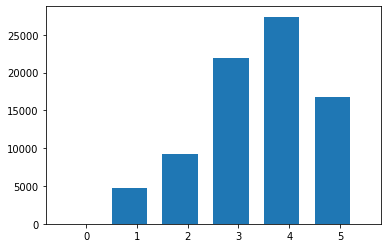

In [84]:
# Inspect the read matrices
data_inst = data_class()

print("Training Matrix")
print(data_inst.train_sparse[:5, :5].todense())
print(data_inst.train_sparse.shape)
print(data_inst.train_sparse.nnz)

print("Test Matrix")
print(data_inst.test_sparse[:5, :5].todense())
print(data_inst.test_sparse.shape)
print(data_inst.test_sparse.nnz)

# Distribution plots
ratings = data_inst.Y_train
print(len(ratings))
plt.hist(ratings, bins = np.arange(0, 7), align = 'left', width = 0.7)
plt.show()

# Evaluation Metric
To evaluate the performance of each method, we will utilize RMSE (Root Mean Squared Error) as the evaluation metric which computes the rating prediction error. Given 'r' as the actual rating, 'r_hat' the predicted rating and 'n' ratings to predict in test set, RMSE is defined as, sqrt(mean((y_hat - y)**2)) for all ratings in test set.

More details on RMSE can be found here - https://en.wikipedia.org/wiki/Root-mean-square_deviation

In [85]:
def rmse(test_mat, r_hat):
    (rows, cols) = test_mat.nonzero()
    rmse = 0
    for i in np.arange(test_mat.nnz):
        actual = test_mat[rows[i], cols[i]]
        prediction = r_hat[rows[i], cols[i]]
        error = (prediction - actual)
        rmse += (error * error)
    
    rmse /= (1.0 * test_mat.nnz)
    rmse = math.sqrt(rmse)
    return rmse

# Problem 1: Global Average Rating
Implment an un-personalized recommendation algorithm where the global average rating for each item over all users who have rated that item in the training data set is used as the predicted rating. This means, for a given movie the same prediction value is used for all (un-rated) users. 

In [86]:
print(data_inst.train_sparse.todense().shape)

dense_mat = data_inst.train_sparse.todense()

dense_mat[0,:].shape

(943, 1682)


(1, 1682)

In [87]:
# Compute rating means for each item
def get_item_avg(sparse_mat):
    ## YOUR CODE HERE
    item_sums = []
    item_counts = []
    dense_mat = sparse_mat.todense()
    for i in range(dense_mat.shape[1]):
        item_rates = dense_mat[:,i]
        item_sums.append(np.sum(item_rates))
        item_counts.append(np.count_nonzero(item_rates))
    item_means = np.array(item_sums) / np.array(item_counts)

    # Handle NaN due to divide by zero
    item_means[np.isnan(item_means)] = 0
    return item_means

data_inst = data_class()
train_sparse = data_inst.train_sparse
test_sparse = data_inst.test_sparse


# Compute the average item rating 
item_means = get_item_avg(train_sparse)
print("Item Averages: %s" % (item_means))

## YOUR CODE HERE
# Compute the R_hat matrix.
R_hat_avg_rating = np.tile(item_means, (test_sparse.shape[0], 1))
print('Shape of R_hat:', R_hat_avg_rating.shape)

## YOUR CODE HERE
# Compute test rmse
test_rmse = rmse(test_sparse, R_hat_avg_rating)
print("Test RMSE: %.4f" % test_rmse)

Read: ./ml-100k/u1.base, Rows: 80000, Cols: 4
Read: ./ml-100k/u1.test, Rows: 20000, Cols: 4
Item Averages: [3.89295039 3.18095238 3.         ... 2.         3.         3.        ]
Shape of R_hat: (943, 1682)


/var/folders/nl/jzl2sdyd5g7gv2bk8lfg29tr0000gn/T/ipykernel_96248/1481625693.py:11: RuntimeWarning: invalid value encountered in true_divide
  item_means = np.array(item_sums) / np.array(item_counts)


Test RMSE: 1.0361


Global item average rating seems to be doing pretty well with a RMSE close to 1.0. Any guesses on why do you think it is a doing a good job even though it is a non-personalized method?
Hint: Plot and compare the item average rating histogram with test set's rating histogram.

(Write down your answer here)

**Answer:**

Because the average rating reflects the average level of the movie, most USER ratings are around this average score, so even in the test set, there is no large error in calculating the MSE of the actual value versus the average.

Also, when calculating MSE, only the ratings that exist will be added to the calculation. Those movies with high popularity will have more people rating them and the average score will be more accurate, thus reducing the MSE in the test dataset, while other movies with low popularity will have less people rating them, and even if some of the ratings used for the test deviate too much from the average, very low number of them will not increase the MSE value too much.

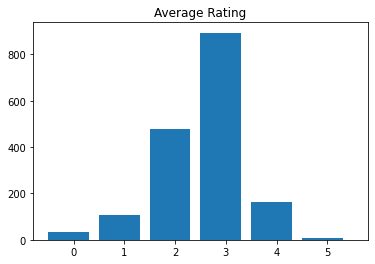

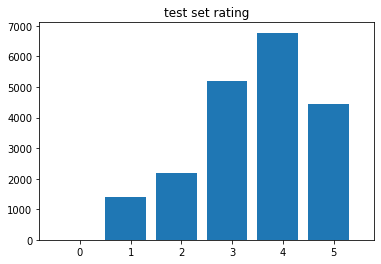

In [88]:
# Plot the item_means distribution
plt.hist(item_means, bins = np.arange(0, 7), align = 'left', width = 0.8)
plt.title('Average Rating')
plt.show()
plt.hist(test_sparse.data, bins = np.arange(0, 7), align = 'left', width = 0.8)
plt.title('test set rating')
plt.show()

# Problem 2: Sparse SVD
Perform SVD on the matrix train_sparse to compute the 'k' dimensional user and item factor matrices. Utilize the user and item factor matrices to predict the ratings for test_sparse matrix and then compute the RMSE.

Note, 
1. To compute the SVD, fill in the missing entries in train_sparse with 0. 
1. Since train_sparse is a sparse matrix, utilize the svds method from scipy

In [89]:
# Sparse SVD
import scipy.sparse.linalg as sla

data_inst = data_class()
train_sparse = data_inst.train_sparse
n_factors = 10

## YOUR CODE HERE
# Compute the sparse svd using svds
Uslice, Sslice, Vslice = sla.svds(train_sparse.todense())
print(Uslice.shape, Sslice.shape, Vslice.shape)

## YOUR CODE HERE
# Compute the R_hat_svd
test_sparse = data_inst.test_sparse
R_hat_svd = Uslice.dot(np.diag(Sslice)).dot(Vslice)
print("Training Loss: %.15f" % (la.norm(train_sparse.todense() - R_hat_svd)))

## YOUR CODE HERE
# Compute the RMSE for test set using the rmse() function
test_rmse = rmse(test_sparse, R_hat_svd)
print("Test RMSE: %.4f" % test_rmse)

Read: ./ml-100k/u1.base, Rows: 80000, Cols: 4
Read: ./ml-100k/u1.test, Rows: 20000, Cols: 4
(943, 6) (6,) (6, 1682)
Training Loss: 831.826984903358721
Test RMSE: 2.9162


SVD seems to be doing a poor job compared to Global Item Average Rating in terms of RMSE on test set. Any guesses on why this is so? This about this before heading into the next question.
Hint: What are we filling the missing values in the matrix with? How does that value affect the SVD factorization?

We'll explore more on this in the next problem

**Answer:**
This SVD method seems did a bad job because we are filling the missing values with 0. Because the dataset is a sparse dataset, we are filling in a lot of 0s into the data matrix. The filled zeros are not ignored but are used as a valid score in the SVD calculation. In fact, the user's rating is at least 1, and in most cases, the predicted user's rating should be around the average, which leads to a large error between the actual results and predicted result from the SVD.

# Problem 3: SVD with Imputed Values
The not so good performane of the SVD in terms of RMSE on test set can be attributed to the fact that we are imputing the missing values with zeros. Thus, SVD tries to factorize the imputed matrix to fit zeros for missing values, thereby increasing the test RMSE. Instead of imputing the missing values with zeros, we can do a better job by utilizing the existing training data and impute the missing value with either the global item average rating or user average rating. Utilize the item_means that you calculated before to fill in the missing values in the train array before computing the SVD

In [90]:
# Impute with Item/User Averages
train_dense = train_sparse.todense()
n_factors = 6

## YOUR CODE HERE
# Compute item averages (utilize the code that you implemented in problem 1)
item_means = get_item_avg(train_sparse)

## YOUR CODE HERE
# Replace zeros in train_dense with their corresponding item average value. 
# You can get/set a specific value (i, j) in train_dense using train_dense[i, j]
for j in range(train_dense.shape[1]):
    train_dense[:, j][train_dense[:, j]==0]=item_means[j]


## YOUR CODE HERE
# Now that the matrix is dense, utilize the dense svd to compute the factor matrices
U, S, V = sla.svds(train_dense, k=6)
print(U.shape, S.shape, V.shape)

## YOUR CODE HERE
# Compute the sliced matrices based on n_factors
Uslice = U[:, :n_factors]
Sslice = S[:n_factors]
Vslice = V[:n_factors, :]
print(Uslice.shape, Sslice.shape, Vslice.shape)

## YOUR CODE HERE
# Compute R_hat_dense_svd
R_hat_dense_svd = Uslice.dot(np.diag(Sslice)).dot(Vslice)
print("Training Loss: %.15f" % (la.norm(train_dense - R_hat_dense_svd)))

# Compute test RMSE
test_rmse = rmse(test_sparse, R_hat_dense_svd)
print("Test RMSE: %.4f" % test_rmse)

/var/folders/nl/jzl2sdyd5g7gv2bk8lfg29tr0000gn/T/ipykernel_96248/1481625693.py:11: RuntimeWarning: invalid value encountered in true_divide
  item_means = np.array(item_sums) / np.array(item_counts)


(943, 6) (6,) (6, 1682)
(943, 6) (6,) (6, 1682)
Training Loss: 265.471545812317061
Test RMSE: 0.9996


In [91]:
# User means
# Compute rating means for each uesr
def get_user_avg(sparse_mat):
    ## YOUR CODE HERE
    user_sums = []
    user_counts = []
    dense_mat = sparse_mat.todense()
    for i in range(dense_mat.shape[0]):
        user_rates = dense_mat[i,:]
        user_sums.append(np.sum(user_rates))
        user_counts.append(np.count_nonzero(user_rates))
    user_means = np.array(user_sums) / np.array(user_counts)

    # Handle NaN due to divide by zero
    user_means[np.isnan(user_means)] = 0
    return user_means

data_inst = data_class()
train_sparse = data_inst.train_sparse
test_sparse = data_inst.test_sparse

# Compute the average user rating 
user_means = get_user_avg(train_sparse)
print('Shape of user_means:',user_means.shape)

## YOUR CODE HERE
# Compute the R_hat matrix.
R_hat_avg_rating = np.tile(user_means.reshape(len(user_means),1), (test_sparse.shape[1]))
print('Shape of R_hat:', R_hat_avg_rating.shape)
print(R_hat_avg_rating[1][2])

## YOUR CODE HERE
# Compute test rmse
test_rmse = rmse(test_sparse, R_hat_avg_rating)
print("Test RMSE: %.4f" % test_rmse)

Read: ./ml-100k/u1.base, Rows: 80000, Cols: 4
Read: ./ml-100k/u1.test, Rows: 20000, Cols: 4
Shape of user_means: (943,)
Shape of R_hat: (943, 1682)
3.8
Test RMSE: 1.0630


We can see that by imputing with item averages the performance drastically improved and it now performs better than item global average (non-personalized method). How would the performance change if user average ratings are utilized instead of item average ratings? Go back and try it out and see which one performs better

**Answer:**
The RMSE of user global average is 1.0630, and the RMSE of item global average is 1.0361. The RMSE of item global average is a little smaller than RMSE of user global average. This difference is very small.

# Problem 4: SVD on Global Average Rating Values 
In problem 3, we imputed the missing values of user rating matrix with global item average ratings and performed the SVD on the imputed matrix. Instead, what if we utilized only the global average ratings for each user and then performed SVD on that. That is, every user has the same set of ratings (same as R_hat_avg_rating from Problem 1). How would the performance (test RMSE) change based on changing n_factors (20, 10, 5, 1)? Do you observe anything strange? 

Hint: Examine the singular values in S matrix

In [92]:
n_factors = [20, 10, 5, 1]

## YOUR CODE HERE
# Utilize the R_hat_avg_rating to compute the SVD factor matrices
R_hat_avg_rating = np.tile(item_means, (test_sparse.shape[0], 1))
U, S, V = sla.svds(R_hat_avg_rating, k=20)
# print("Shape of U,S,V: ", U.shape, S.shape, V.shape)
    
for n in n_factors:
    print("n = ", n)

    Uslice = U[:, :n]
    Sslice = S[:n]
    Vslice = V[:n, :]
    # print("Shape of U,S,V sliced: ", Uslice.shape, Sslice.shape, Vslice.shape)

    ## YOUR CODE HERE
    # Compute the R_hat_svd_avg_rating matrix using the slice matrices from above
    R_hat_svd_avg_rating = Uslice.dot(np.diag(Sslice)).dot(Vslice)
    print("Training Loss: %.15f" % (la.norm(train_dense - R_hat_svd_avg_rating)))

    test_rmse = rmse(test_sparse, R_hat_svd_avg_rating)
    print("Test RMSE: %.4f" % test_rmse)

print("S = ", S)

n =  20
Training Loss: 281.613942109279492
Test RMSE: 1.0361
n =  10
Training Loss: 3991.511420036853906
Test RMSE: 3.7193
n =  5
Training Loss: 3991.511420036853906
Test RMSE: 3.7193
n =  1
Training Loss: 3991.511420036853906
Test RMSE: 3.7193
S =  [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.         3981.56464269]


**Answer:**

The performance of full SVD is same to the global average rating. The performance of other sliced SVD with factors n is same, and the RMSE is 3.7193. It is a huge error.

When print the S out, we find there are only one non-zero value in S matrix and it is the last one in S. Because of this, no matter what number the factor n is, the sliced SVD will cut out this only non-zero value. In this case, all the number in r_hat is 0, and the RMSE is calculate the error between 0 and true rating score.

# Problem 5: SGD
Implement SGD method to compute the user and item factor matrices (U and V). (In the assignment code below, we use Pytorch (actually Torch) as the framework for implementing automatic differentiation. However, you can also use Pytorch to do the same.)  Utilize the computed U and V matrices to compute the prediction for test_sparse matrix and compute the RMSE. Tune different hyperparameters and understand how they impact the train and test RMSE. 

This problem is broken down into multiple classes. You need to fill in some code in each of the classes. Each class has an associated unit test function which will help you validate if you have coded that class correctly.

## SGD Model Class 

This class contain the model parameters and computes the rating predictions based on the current state of the model parameters

In [94]:
import torch

class model:
    def __init__(self, n_factors, mx_row, mx_col):
        self.n_factors = n_factors
        self.mx_row = mx_row
        self.mx_col = mx_col
        self.initialize_model_parameters()
    
    def initialize_model_parameters(self):
        ## YOUR CODE HERE
        # Initialize the model parameters U and V using torch random matrix initializer
        # Make sure to require gradient support (requires_grad) parameter
        self.U = torch.rand(self.mx_row, self.n_factors, requires_grad=True)
        self.V = torch.rand(self.n_factors, self.mx_col, requires_grad=True)
        
    
    def simple_prediction(self, u, v):
        ## YOUR CODE HERE
        # Compute the prediction for a given user 'u' and item 'v' vector
        # Refer back to lecture on how the prediction was calculated
        predictions = self.U.dot(self.V)
        return predictions

    def get_n_factors(self):
        return self.n_factors    

def test_model():
    k = 10
    m = 100
    n = 200
    model_inst = model(k, m, n)
    print("U Shape: (%d, %d), Expected U shape: (%d, %d)" % (model_inst.U.shape[0], model_inst.U.shape[1], m, k))
    print("V Shape: (%d, %d), Expected V shape: (%d, %d)" % (model_inst.V.shape[0], model_inst.V.shape[1], k, n))

    
test_model()


U Shape: (100, 10), Expected U shape: (100, 10)
V Shape: (10, 200), Expected V shape: (10, 200)


## SGD - Metrics Class

This class is a more sophisticated version of the RMSE function we saw earlier. Along with computing the RMSE for test set, this class also contains computation of loss function for the SGD iterations

In [96]:
class metrics:
    def __init__(self):
        pass
    
    def square_loss(self, y_hat, y):
        ## YOUR CODE HERE
        # Return the normalized squared loss between y_hat and y
        return torch.mean(torch.pow((y_hat - y), 2))
    
    def RMSE(self, y_hat, y):
        return torch.pow(self.square_loss(y_hat,y),0.5)
    
    def all_loss_RMSE(self, X, Y, n_factors, model_inst):
        
        # Compute loss and RMSE and return both
        with torch.no_grad():
            pred = torch.matmul(model_inst.U,model_inst.V)
        return self.square_loss(pred, torch.tensor(Y).reshape(-1)),  self.RMSE(pred, torch.tensor(Y).reshape(-1))


def test_metrics():
    x = torch.tensor([1, 2, 3, 4])
    x = x.type(torch.FloatTensor)
    y = torch.tensor([4, 5, 6, 7])
    y = y.type(torch.FloatTensor)
    expected_loss = 9.0
    metrics_inst = metrics()
    print("Square Loss: %f, Expected Square Loss: %f" % (metrics_inst.square_loss(x, y), expected_loss))
    
test_metrics()

Square Loss: 9.000000, Expected Square Loss: 9.000000


## SGD - Optimizer Class

This class updates the model parameters based on the computed gradients. This utilizes the autograd to compute the gradients.

In [ ]:
class optimizer:
    def __init__(self, lr):
        self.lr = lr

    def SGD(self, model_inst):
        #for data in self.data_batch:
        #print("Data shape = ", self.data_batch.shape)
        indU = list(set(self.data_batch[:,0]))
        indV = list(set(self.data_batch[:,1]))

        ## YOUR CODE HERE
        # Update the corresponding rows of U and V using the gradient update rule
        # parameter = parameter - learning_rate * gradient(parameter)
        # Use autograd to compute the gradients
        with torch.no_grad(): # This is required to prevent gradient attached error
            model_inst.U[indU,:] -=  # Formula for gradient descent for U - Key thing is to only update the relevant parts of U matrix
            model_inst.V[:,indV] -=  # Formula for gradient descent for V - Key thing is to only update the relevant parts of V matrix

    def optimization(self, data_batch, model_instance):
        self.data_batch = data_batch
        self.SGD(model_instance)

## SGD - Trainer Class

This class performs the training iterations. It iterates through the training data samples and updates the model parameters based on their gradient

In [ ]:
import numpy as np

class Trainer:
    def __init__(self, learning_rate = 0.5, epochs = 10, regularization_weight = 0):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.regularization_weight = regularization_weight
        self.training_RMSE = np.zeros((self.epochs, 1))
        self.testing_RMSE = np.zeros((self.epochs, 1))
    
    def print_metrics(self,epoch,train_rmse,test_rmse):
        print("EPOCH = %d, train_rmse = %f, test_rmse = %f \n" % (epoch, float(train_rmse), float(test_rmse)))
    
    def get_metrics(self):
        return self.training_RMSE, self.testing_RMSE
    
    def train(self, model_instance, data_inst):
        # Refresh model parameters
        model_instance.initialize_model_parameters()
        
        # Initialize optimizer
        optimizer_inst = optimizer(self.learning_rate)
        
        # Initialize metrics
        metrics_inst = metrics()
        
        print(data_inst.data_loader)
        for epoch in range(self.epochs):
            running_loss = 0.0
            count = 0
            # Iterate over the mini batches
            # Make sure you understand the shape of data and label before proceeding further
            for data in data_inst.data_loader:
                #print(data.shape)
                #print(data)
                ## YOUR CODE HERE
                # Get the set of indices for U and V for the current batch of training samples in data
                indU = data[:,0]
                indV = data[:,1]
                Y = data[:,2]
                
                ## YOUR CODE HERE
                # Subset the rows of U and V to only indU and indV. Hint: use slicing operations
                u = 
                v = 

                
                ## YOUR CODE HERE
                # Compute the prediction for the user 'u' and item 'v' using model_instance 
                pred = 
            
                ## YOUR CODE HERE
                # Compute the squared loss using metrics_inst
                # The loss should only depend on the data that is part of the mini batch and 
                # also only on the subset of the parameters U,V that were computed couple of steps earlier. 
                loss = 
                        
                
                # Back Propagate gradients
                loss.backward() # Once loss is computed, loss.backward() updates the gradient of the parameters and stores it as such
                                # So once this is done, as an example, U.grad gives you the updated gradient for U, etc
                
                ## YOUR CODE HERE
                # Optimization - update the model parameters using optimizer_inst
                optimizer_inst.optimization(data,model_inst)
                
                count += 1
                
            # Compute the training and test loss and RMSE after each epoch!
            training_loss, train_RMSE = metrics_inst.all_loss_RMSE(data_inst.X_train,\
                    data_inst.Y_train, model_instance.n_factors, model_instance)
            test_loss, test_RMSE = metrics_inst.all_loss_RMSE(data_inst.X_test, \
                    data_inst.Y_test, model_instance.n_factors, model_instance)
            
            # Print metrics
            self.print_metrics(epoch, train_RMSE, test_RMSE)
            
            self.training_RMSE[epoch, 0] = train_RMSE
            self.testing_RMSE[epoch, 0] = test_RMSE
    

## SGD - Config Class

This class contains the set of hyper parameters that the SGD algorithm uses. Tuning these parameters is critical to get the best performance out of the algorithm.
For this specific data set, we have provided a range of values for each of these hyper parameters to test. To start, pick a value for each hyper parameter in the range.

In [ ]:
class config:
    def __init__(self):
        self.config()
        
    def config(self):
        ## YOUR CODE HERE
        # Initialize the model hyper parameters based on the suggested range
        self.batch_size = 64 # (50, 200)
        self.learning_rate =   # (1e-3, 0.1, 1.0)
        self.epochs =  10 # (5, 10, 100) # 10 might be a good point to start, increasing this increases the optimization run time linearly
        self.n_factors =   # (5, 50)


## SGD Visualizing Errors

To visualize the train and test errors as a function of number of iterations of the SGD algorithm, the following code snippet provides the functionality to generate the plot. Collect the train and test errors in each iteration and call this method to generate the plot

In [ ]:
from matplotlib import pyplot as plt

def plot_metrics(train_RMSE, test_RMSE):
    epochs = range(len(train_RMSE))
    plt.plot(epochs, train_RMSE, 'b', label = "Train RMSE")
    plt.plot(epochs, test_RMSE, 'g', label = "Test RMSE")
    plt.title('RMSE vs Epochs')
    plt.legend()

## SGD - Main function

This is the main function which binds all the functionality we have created so far.

In [ ]:
## SGD Main Function
# Load configuration of hyper parameters

from torch.utils.data import TensorDataset, DataLoader

config_inst = config()

# Load train and test data
data_inst = data_class()

# Data Loader for training data
# This is helpful to create mini-batches for optimization
XY_train = torch.tensor(np.hstack((data_inst.X_train,data_inst.Y_train)))
data_loader = DataLoader(XY_train,batch_size=config_inst.batch_size,shuffle=True) 
# shuffle=True ensures there is random shuffling of batches when sampling from DataLoader - mimicking random mini-batches

data_inst.add_data_loader(data_loader)

## YOUR CODE HERE
# Create a model instance based on the corresponding config_inst values
rows = # Plug in the appropriate number of rows
cols = # Plug in the appropriate number of cols

model_inst = model(config_inst.n_factors,rows,cols)

## YOUR CODE HERE
# Create a Trainer Instance based on the corresponding config_inst values
trainer_inst = 

## YOUR CODE HERE
# Train the model using the trainer instance, model_inst and data_inst
trainer_inst.train(model_inst,data_inst)

## YOUR CODE HERE
# Get the training and test metrics using trainer_inst
training_RMSE, testing_RMSE = 

# Plot the Errors
plot_metrics(training_RMSE, testing_RMSE) # If you go the SGD mini-batch going right, this plot will curve downwards for both train and test


Even though SGD is performing slightly better than user/item average imputed SVD, we expect the SGD to perform much better. Looking at the train and test error plot, can you guess what might be the issue with the current optimization? And what can we do to fix it?

Hint: Overfitting

# Problem 6: SGD with Regularization

From the error plot in Problem 5 we can see that the test RMSE decreases with train RMSE for first few iterations, but after that the test RMSE starts to increase or remains flat, even though the train RMSE is increasing. This is a good indicator for overfitting. Like we say in the lecture, adding regularization is one of the ways to fix this. 

Implement the l2 regularization to the SGD code above and compare the performence with and without the regularization. Do you see the expected benefit?

Hint: Following are the specific changes you need to do in the code to add the regularization

1. Update the config class to include a regularization weight hyper parameter (regularization_weight). A value in (0.1, 10) is a good range to try for this hyper parameter.
1. Add a function in metrics class to compure the square loss with regularization. Signature of that function is given by square_loss_regularized(self, y_hat, y, u, v, regularization_weight)
1. Update the trainer class constructor to take in the regularization_weight as a parameter
1. Update the Trainer.train() method to compute the new loss with regualrization. Remember, autograd will take care of computing the updated gradient, as long as the loss function computation is correct.
1. Finally update the main() to pass in the regularization_weight parameter to the trainer class.